## 7. Fourier-transzformációs módszer, FFTMethod

Alapvetően a kiértékelés a lépései:

**betöltés &rarr; előfeldolgozás &rarr; IFFT &rarr; ablakolás &rarr; FFT &rarr; fázis**

Az ajánlott sorrend a függvények hívásában is ez, mivel nem garantált, hogy a tengelyek helyesen fognak transzformálódni tetszőleges sorrendű transzformációk után.

Szimulált példák:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysprint as ps

In [2]:
g = ps.Generator(1, 4, 2.5, 1500, GDD=400, TOD=400, FOD=1000, pulse_width=4, resolution=0.05)
g.generate_freq()

Egy automatikus kiértékelés:

Interferogram received.
Applying IFFT...Done
Acquiring gaussian window parameters...Done
A 12 order gaussian window centered at 2670.47 fs with FWHM 4055.09 fs was applied.


c:\pyt\pysprint\pysprint\core\_fft_tools.py:98: UserWarning: The peak is too close to the origin, manual control is advised.
  UserWarning,


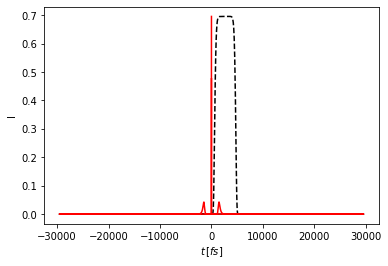

Applying FFT...Done
Calculating...


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

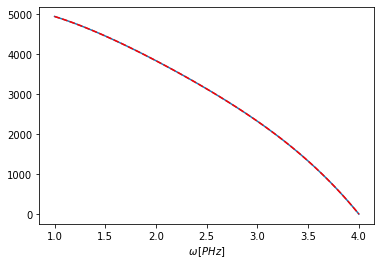

In [3]:
f = ps.FFTMethod(*g.data)
f.autorun(reference_point=2.5, order=4)

Egy másik automatikus kiértékelés (ugyan azon az interferogramon), ezúttal csak a fázist kapjuk meg. Ennek a fázisgrafikonnak a széleit kivágjuk a `slice` függvénnyel, majd a `fit` metódust használva számolhatjuk a diszperziós együtthatókat.

In [4]:
f2 = ps.FFTMethod(*g.data)
phase = f.autorun(show_graph=False, enable_printing=False)

print(type(phase))

phase.slice(1.1, 3.9)

phase.fit(reference_point=2.5, order=4);

c:\pyt\pysprint\pysprint\core\_fft_tools.py:98: UserWarning: The peak is too close to the origin, manual control is advised.
  UserWarning,


<class 'pysprint.core.phase.Phase'>


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Bár látható volt, hogy a program jól határozta meg a Gauss ablakfüggvény paramétereit és ezáltal a diszperziós együtthatókat is, de jelzett, hogy a kivágandó csúcs túl közel van az origóhoz, így jobb ha azt manuálisan állítjuk be. Nézzük meg a fázist az illesztett görbével:

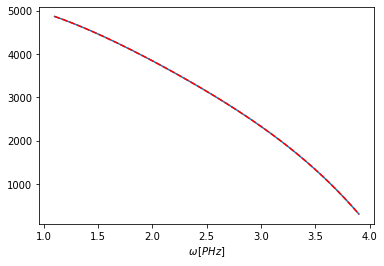

In [5]:
phase.plot()

Majd az illesztési hiba:

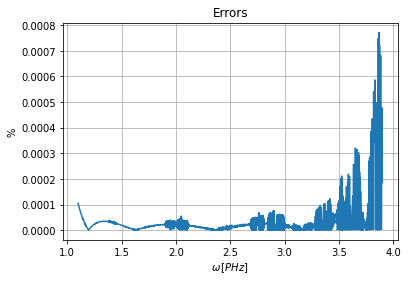

In [6]:
phase.errorplot(percent=True)

Nézzünk meg egy manuális kiértékelést. Itt a nekem meglévő interferogramot fogom használni, ami enyhén szólva sem ideális a Fourier-transzformációs kiértékeléshez, de megpróbálom a legtöbb használható információt kihozni belőle. Mivel már előre tudom hogy hogyan érdemes az ablakfüggvényt beállítani, így itt az ún. `inplace=False` argumentumot fogom használni. Alapvetően minden függvény amit meghívunk `inplace=True` módon hajtódik végre, azaz megváltoztatja magát az objektumot. Így működik pl. a python listáknál az `append` függvény:
```python
>>> a = []
>>> a.append(1)
>>> print(a)
[1]
```
A csomag során sok függvénynél lehetőség van megadni az `inplace=False` argumentumot, ami nem változtatja meg magát az objektumot, hanem visszaad egy új másolatot belőle, és kért függvényt azon a másolaton fogja végrehajtani. Ennek két előnye van: Az eredeti objektum (és így vele minden eredetileg betöltött adatsor) megmarad, és anélkül hogy újra és újra betöltenénk más objektumba az adatokat, ezért elég belőle egy. A második előny pedig abból adódik, hogy megengedi a műveletek láncolását, ahogy az alábbi példa mutatja. ([fluent interfacing](https://en.wikipedia.org/wiki/Fluent_interface) and [method cascading](https://en.wikipedia.org/wiki/Method_cascading)) Itt a szokásos kiértékelési lépéseket hajtottam végre. Az utolsó függvény amit meghívtam rajta, az a `build_phase`, ami egy fázist ad vissza, ezért a hosszú láncolat után az lesz a visszatérített érték (ezt elneveztem `phase3`-nak).

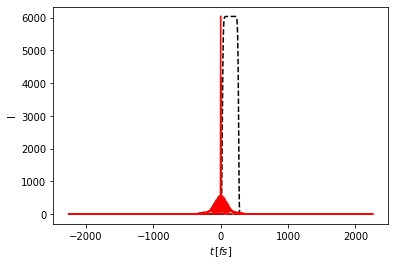

In [7]:
f3 = ps.FFTMethod.parse_raw('datasets/ifg.trt', skiprows=8, meta_len=8, decimal=",", delimiter=";")

phase3 = (
    f3.chdomain(inplace=False)
    .ifft(inplace=False)
    .window(at=145, fwhm=240, window_order=16, inplace=False)
    .apply_window(inplace=False)
    .fft(inplace=False)
    .build_phase()
)

Itt a jobb olvashatóság miatt minden új függvénynél új sort kezdtem és zárójelbe tettem. Ezek nélkül így festene:

In [8]:
phase4 = f3.chdomain(inplace=False).ifft(inplace=False).window(at=145, fwhm=240, window_order=16, plot=False, inplace=False).apply_window(inplace=False).fft(inplace=False).build_phase()

Mivel nem volt ideális az interferogram vizsgáljuk meg milyen fázist kaptunk vissza.

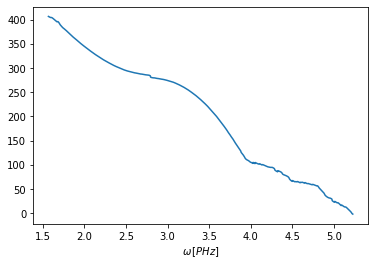

In [9]:
phase3.plot()

Itt észrevehető, hogy vannak olyan részei a görbének, amely valóban tartalmazza a minta fázistulajdonságait. Vágjuk ki ezt a részt a `slice` függvénnyel.

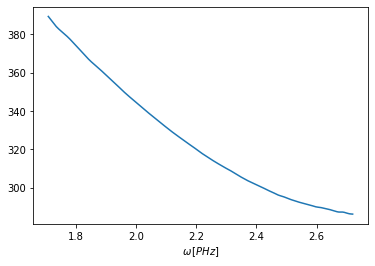

In [10]:
phase3.slice(1.71, 2.72)
phase3.plot()

Ezután végezzük el az illesztést a `fit` függvénnyel:

In [11]:
phase3.fit(reference_point=2.355, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A kapott diszperziós együtthatók valóban jó közelítéssel tükrözik a mintára jellemző (már egyéb módszerekkel meghatározott) koefficienseket. Vizsgáljuk meg az illesztési hibát is:

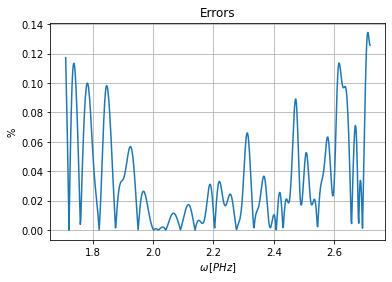

In [12]:
phase3.errorplot(percent=True)

Ugyan ez a kiértékelés hagyományosan, az `inplace=False` paraméterek nélkül így néz ki:

In [13]:
f4 = ps.FFTMethod.parse_raw('datasets/ifg.trt', skiprows=8, meta_len=8, decimal=",", delimiter=";")

f4.chdomain()

f4.ifft()

f4.window(at=145, fwhm=240, window_order=16, plot=False)

f4.apply_window()

f4.fft()

phase4 = f4.build_phase()

phase4.slice(1.71, 2.72)

phase4.fit(2.355, 3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Próbáljuk meg az impulzus időbeli alakját kiszámolni. Ehhez a `get_pulse_shape_from_file` függvényt fogom használni, aminek a tárgykar spektrumát adom meg.

In [14]:
x_t, y_t = f4.get_pulse_shape_from_file("datasets/sam.trt", truncate=True, chdomain=True, skiprows=8, decimal=",", sep=";")

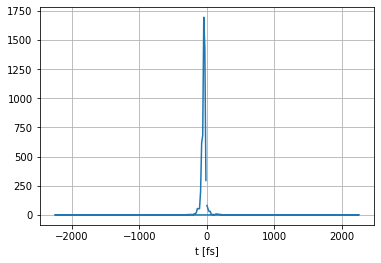

In [15]:
plt.plot(x_t, y_t)
plt.grid()
plt.xlabel("t [fs]");

Mivel a használt interferogram nem volt ideális, így itt az impulzus alakját nem lehetett tökéletesen visszakapni.

Alapértelmezetten néhány dolog el van rejtve a felhasználó elől. Az előző `get_pulse_shape_from_file` függvényt újra lefuttatom, ezúttal teljes logging outputtal. Ezt szinte soha nem kell használnunk, itt is csak a magyarázat miatt van létjogosultsága.

In [16]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

x_t, y_t = f4.get_pulse_shape_from_file("datasets/sam.trt", truncate=True, chdomain=True, skiprows=8, decimal=",", sep=";")

[ fftmethod.py:400 - get_pulse_shape_from_array() ] Shapes were truncated from 2.3226283197396467 to 2.7198388115237 with length 287.


Látható, hogy *2.322* és *2.719 PHz* között 287 adatpontnál sikerült kiszámítani a 
  $I(t) = |\mathcal{F}^{-1}\{\sqrt{|I_{tárgy}(\omega)|}\cdot e^{-i\Phi{(\omega)}}\}|^2$
kifejezés értékét. Ez annak köszönhető, hogy a kiszámolt fázist elég nagy tartományban nem tudtuk felhasználni (eredetileg a *1.71 - 2.72* *PHz* tartományt vágtuk ki), illetve az transzformációk során behozott numerikus hiba is közrejátszott.

Végül a Non-unifrom FFT használata. Itt teljesen ugyan azt hajtom végre, mint fentebb, csak `usenifft=True` argumentummal.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

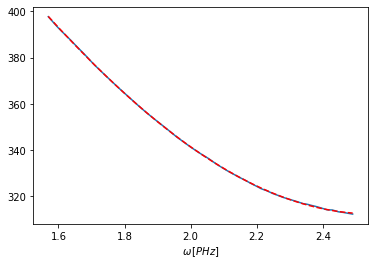

In [17]:
# csak visszaállítom a log szintet az alapértelmezettre, hogy ne árassza el a képernyőt
logger.setLevel(logging.ERROR)

f5 = ps.FFTMethod.parse_raw('datasets/ifg.trt', skiprows=8, meta_len=8, decimal=",", delimiter=";")

f5.chdomain()

f5.ifft(usenifft=True)

f5.window(at=155, fwhm=260, window_order=16, plot=False)

f5.apply_window()

f5.fft()

phase6 = f5.build_phase()

phase6.slice(None, 2.49)
phase6.fit(2.355, 3);
phase6.plot()

A szimulációk alapján a NUFFT valamivel pontatlanabb eredményt ad, mint az interpoláció + FFT.